kWh saved / degree-hour compromised

In [14]:
import pandas as pd
import os

column_name = ['Building type name',
               'Insulation',
               'Thermal Mass'
               #'Weather Location'
               #'Baseline EnergyPlus Heating [kWh/m2/a]', #from htm
               #'Baseline EnergyPlus too warm % time > 25C', #from out csv
               #'Baseline EnergyPlus too cold % time < 20C']
]

base_path = r"W:\Insync\GDrive\Main\TU Delft\Thesis\DRL runs 11"
# EPBaseline', 'RLBaseNoForesight', 'RL24hAllRNN', 'RL24hNoSolarRNN', 'RL04hAllRNN', 'RL04hNoSolarRNN', 'RL04hFlatInput'
control_types_list = ['EPBaseline', 'RL24hAllRNN', 'RL04hAllRNN']#, 'RLBaseNoForesight', 'RL24hNoSolarRNN', 'RL04hNoSolarRNN', 'RL04hFlatInput']

control_pretty_names_list = ['Baseline EnergyPlus simple schedule', 'RL 24h Foresight RNN', 'RL 4h Foresight RNN', 'RL No Foresight', 'RL 24h Foresight RNN w/o Solar', 'RL 4h Foresight RNN w/o Solar', 'RL 4h Foresight flat inputs']
control_pretty_names_list = control_pretty_names_list[0:len(control_types_list)]

saving_kwh_deg = [] # [Base, rl24, rl04], [ ] repeat

week_num = 44

for i in range(52):
    week_num = i  +1

    day_range = (7 * (week_num -1) + 1, 7 * week_num)
    day_range_hours = (7 * (week_num -1) *24, 7 * week_num *24 -1)

    use_full_year = False
    if use_full_year:
        day_range_hours = (0,8760)

    print(day_range)
    print(day_range_hours)

    for name in control_pretty_names_list:
        column_name.append(f'{name} Heating [kWh/m2/a]')
        column_name.append(f'{name} too cold % time < 20C')
        column_name.append(f'{name} too warm % time > 25C')


    building_types_list = [ 'Building-InsuBASE-MassBASE']#,
                            # 'Building-InsuBASE-MassDW',
                            # 'Building-InsuBASE-MassUP',
                            # 'Building-InsuDW-MassBASE',
                            # 'Building-InsuDW-MassDW',
                            # 'Building-InsuDW-MassUP',
                            # 'Building-InsuUP-MassBASE',
                            # 'Building-InsuUP-MassDW',
                            # 'Building-InsuUP-MassUP']


    building_area_m2 = 2480

    rows_combined = []
    for builidng_no, unique_building_name in enumerate(building_types_list):
        
        row_in_saving_kwh_deg = []

        row_in_df = []
        row_in_df.append(unique_building_name)

        if unique_building_name[13] == 'B':
            row_in_df.append('Baseline')
        elif unique_building_name[13] == 'D':
            row_in_df.append('Decreased 50%')
        elif unique_building_name[13] == 'U':
            row_in_df.append('Increased 2x')
        
        if unique_building_name[-1] == 'E':
            row_in_df.append('Baseline')
        elif unique_building_name[-1] == 'W':
            row_in_df.append('Decreased 50%')
        elif unique_building_name[-1] == 'P':
            row_in_df.append('Increased 2x')

        for control_no, unique_control in enumerate(control_types_list):
            htm_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplustbl.htm')
            epluscsv_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplusout.csv')
            meter_path = os.path.join(base_path, unique_building_name, unique_control, 'out', 'eplusmtr.csv')

            dfmeter = pd.read_csv(meter_path)
            heat_GJ_total = dfmeter['DistrictHeating:Facility [J](TimeStep)'][day_range_hours[0]:day_range_hours[1]].sum() / 1_000_000_000

            # htm_file = pd.read_html(htm_path)
            # assert htm_file[4][13][0] == 'District Heating [GJ]', 'Wrong column/table from .HTM file'
            # heat_GJ_total = float(htm_file[4][13][1]) #GJ total building 1 year

            heat_kWh_m2 = heat_GJ_total * 277.8 / building_area_m2

            row_in_df.append(heat_kWh_m2)
            # print(heat_kWh_m2, ' kWh/m2/a for heating')

            # CSV for temperature ranges
            epluscsv = pd.read_csv(epluscsv_path)

            if unique_control == 'EPBaseline':
                dates = pd.date_range('2007-01-01', periods=8760, freq='H')
            else:
                dates = pd.date_range('2007-01-01', periods=8760, freq='H')

            #creating pandas Series with date index
            s = pd.Series(dates)
            epluscsv['Date/Time'] = s # s.dt.dayofweek # 0-6 Mon-Sun

            # count_too_cold = epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
            #             (epluscsv['Date/Time'].dt.dayofweek < 5) &
            #             (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
            #             (epluscsv.index >= day_range_hours[0]) &
            #             (epluscsv.index <= day_range_hours[1])
            #             ].count()['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']
            # row_in_df.append(count_too_cold)
            # print(count_too_cold, ' days too cold')

            # count_too_warm = epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] > 25) &
            #             (epluscsv['Date/Time'].dt.dayofweek < 5) &
            #             (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
            #             (epluscsv.index >= day_range_hours[0]) &
            #             (epluscsv.index <= day_range_hours[1])
            #             ].count()['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']
            # row_in_df.append(count_too_warm)
            # print(count_too_warm, ' days too warm')

            # *****************

            degree_hours_cold = (20 - epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] < 20) &
                (epluscsv['Date/Time'].dt.dayofweek < 5) &
                (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
                (epluscsv.index >= day_range_hours[0]) &
                (epluscsv.index <= day_range_hours[1])
                ]['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']).sum()

            # print('Degree hours cold: ', degree_hours_cold)
            row_in_df.append(degree_hours_cold)

            degree_hours_hot = (25 - epluscsv[(epluscsv['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)'] > 25) &
                (epluscsv['Date/Time'].dt.dayofweek < 5) &
                (epluscsv['Date/Time'].dt.hour.between(8, 15, inclusive='both')) &
                (epluscsv.index >= day_range_hours[0]) &
                (epluscsv.index <= day_range_hours[1])
                ]['Z2_FIRST_FLOOR:Zone Operative Temperature [C](Hourly)']).sum() *-1

            # print('Degree hours hot: ', degree_hours_hot)
            row_in_df.append(degree_hours_hot)

            if degree_hours_cold != 0:
                sav_kwh_deg = heat_kWh_m2 / degree_hours_cold
            elif degree_hours_cold == 0:
                sav_kwh_deg = heat_kWh_m2 / 0.001
            row_in_saving_kwh_deg.append(sav_kwh_deg)





        saving_kwh_deg.append(row_in_saving_kwh_deg)
        rows_combined.append(row_in_df)

    # print(rows_combined)
    # print(saving_kwh_deg)
    print(saving_kwh_deg[i][1] - saving_kwh_deg[i][0])


    # df = pd.DataFrame(rows_combined, columns=column_name)
    # df

(1, 7)
(0, 167)
-1.1744950331027655
(8, 14)
(168, 335)
-0.49641509886963775
(15, 21)
(336, 503)
-0.8641647639264002
(22, 28)
(504, 671)
-0.8739202358763003
(29, 35)
(672, 839)
-0.5654489565664191
(36, 42)
(840, 1007)
-0.7699605026296078
(43, 49)
(1008, 1175)
-0.46837339274891915
(50, 56)
(1176, 1343)
-0.7837688395266488
(57, 63)
(1344, 1511)
-8.823431934105706
(64, 70)
(1512, 1679)
-1.4000257172391617
(71, 77)
(1680, 1847)
-2.109811451927474
(78, 84)
(1848, 2015)
-164.76095661388268
(85, 91)
(2016, 2183)
-6.918978916807055
(92, 98)
(2184, 2351)
-11.569933199111304
(99, 105)
(2352, 2519)
-230.95061588663793
(106, 112)
(2520, 2687)
-0.9498021215397805
(113, 119)
(2688, 2855)
-24.44877202353545
(120, 126)
(2856, 3023)
-39.35370234599904
(127, 133)
(3024, 3191)
-8.36558015887788
(134, 140)
(3192, 3359)
0.0
(141, 147)
(3360, 3527)
-0.2918552581542944
(148, 154)
(3528, 3695)
0.0
(155, 161)
(3696, 3863)
0.0
(162, 168)
(3864, 4031)
0.0
(169, 175)
(4032, 4199)
0.0
(176, 182)
(4200, 4367)
0.0
(1

In [15]:
saving_df = pd.DataFrame(saving_kwh_deg, columns=control_types_list)
saving_df

,EPBaseline,RL24hAllRNN,RL04hAllRNN
0,1.207644,0.033149,0.227224
1,0.524642,0.028227,0.109839
2,0.905233,0.041069,0.140559
3,0.915257,0.041336,0.144769
4,0.598114,0.032665,0.137844
5,0.819318,0.049357,0.207027
6,0.495946,0.027573,0.062016
7,0.813578,0.029810,0.092777
8,8.858137,0.034705,0.309561
9,1.445869,0.045843,0.284574


<Axes: >

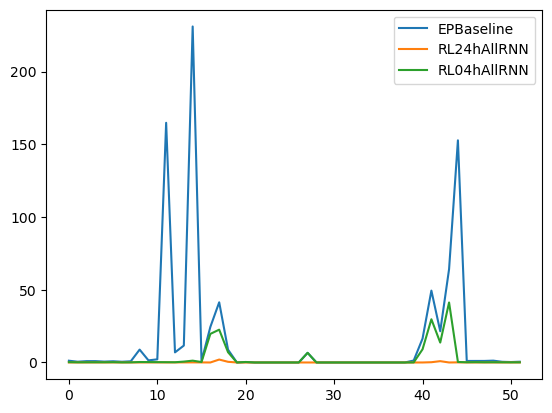

In [16]:
saving_df.plot()